In [25]:
import contractions
import string
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from datasets import load_dataset

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

In [26]:
dataset = load_dataset('cnn_dailymail', '3.0.0')

Found cached dataset cnn_dailymail (C:/Users/vijay/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:00<?, ?it/s]

In [27]:
train_data = dataset['train']
train_df = pd.DataFrame(train_data).sample(frac=0.1)

In [28]:
validation_data = dataset['validation']
validation_df = pd.DataFrame(validation_data).sample(frac=0.1)

In [29]:
test_data = dataset['test']
test_df = pd.DataFrame(test_data).sample(frac=0.1)

In [30]:
nltk.download('wordnet')
def preprocess_text(text):
    
    text = text.lower()
    
    text = text.translate(str.maketrans("", "", string.punctuation))

    text = re.sub(r"[^\w\s]", "", text)

    text = ''.join([char for char in text if char.isalpha() or char.isspace()])

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token, wordnet.VERB) for token in tokens]

    preprocessed_text = ' '.join(tokens)
    
    preprocessed_text = contractions.fix(preprocessed_text)

    return preprocessed_text

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vijay\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [31]:
train_df['article'] = train_df['article'].apply(preprocess_text)

In [32]:
train_articles = train_df['article'].tolist()
train_summaries = train_df['highlights'].tolist()

In [33]:
test_articles = test_df['article'].tolist()
test_summaries = test_df['highlights'].tolist()

In [34]:
validation_articles = validation_df['article'].tolist()
validation_summaries = validation_df['highlights'].tolist()

In [35]:
article_tokenizer = Tokenizer()
article_tokenizer.fit_on_texts(train_articles + validation_articles + test_articles)

summary_tokenizer = Tokenizer()
summary_tokenizer.fit_on_texts(train_summaries + validation_summaries + test_summaries)

In [36]:
train_articles_seq = article_tokenizer.texts_to_sequences(train_articles)
train_summaries_seq = summary_tokenizer.texts_to_sequences(train_summaries)

validation_articles_seq = article_tokenizer.texts_to_sequences(validation_articles)
validation_summaries_seq = summary_tokenizer.texts_to_sequences(validation_summaries)

test_articles_seq = article_tokenizer.texts_to_sequences(test_articles)
test_summaries_seq = summary_tokenizer.texts_to_sequences(test_summaries)

In [37]:
article_max_len = 500
summary_max_len = 50

train_articles_seq = pad_sequences(train_articles_seq, maxlen=article_max_len, padding='post')
train_summaries_seq = pad_sequences(train_summaries_seq, maxlen=summary_max_len, padding='post')

In [38]:
validation_articles_seq = pad_sequences(validation_articles_seq, maxlen=article_max_len, padding='post')
validation_summaries_seq = pad_sequences(validation_summaries_seq, maxlen=summary_max_len, padding='post')

In [39]:
test_articles_seq = pad_sequences(test_articles_seq, maxlen=article_max_len, padding='post')
test_summaries_seq = pad_sequences(test_summaries_seq, maxlen=summary_max_len, padding='post')

In [40]:
# Define the input/output shapes and vocabulary size
article_vocab_size = len(article_tokenizer.word_index) + 1
summary_vocab_size = len(summary_tokenizer.word_index) + 1
embedding_dim = 200

In [41]:
encoder_inputs = Input(shape=(article_max_len,))
encoder_embedding = Embedding(article_vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
encoder_lstm1 = LSTM(128, return_sequences=True, return_state=True)
encoder_outputs1, _, _ = encoder_lstm1(encoder_embedding)
encoder_lstm2 = LSTM(128, return_sequences=True, return_state=True)
encoder_outputs2, _, _ = encoder_lstm2(encoder_outputs1)
encoder_lstm3 = LSTM(128, return_sequences=False, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_outputs2)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(summary_max_len,))
decoder_embedding = Embedding(summary_vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(128, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
# decoder_dense = TimeDistributed(Dense(summary_vocab_size, activation='softmax'))
# decoder_outputs = decoder_dense(decoder_outputs)

# # Create the model
# model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


In [42]:
# Attention mechanism
attention = tf.keras.layers.Attention()([decoder_outputs, encoder_outputs])
context_vector = tf.keras.layers.Concatenate(axis=-1)([decoder_outputs, attention])

# Pointer network
pointer_probs = TimeDistributed(Dense(1, activation='sigmoid'))(context_vector)
pointer_probs = tf.keras.layers.Flatten()(pointer_probs)
pointer_probs = tf.keras.layers.RepeatVector(summary_max_len)(pointer_probs)

# Final probabilities
vocab_probs = TimeDistributed(Dense(summary_vocab_size, activation='softmax'))(decoder_outputs)
final_probs = K.concatenate([vocab_probs, pointer_probs], axis=-1)

model = Model([encoder_inputs, decoder_inputs], final_probs)

In [43]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Print the model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 500, 200)     41671200    ['input_3[0][0]']                
                                                                                                  
 lstm_4 (LSTM)                  [(None, 500, 128),   168448      ['embedding_2[0][0]']            
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                            

In [44]:
# Fit the model
history = model.fit(
    [train_articles_seq, train_summaries_seq],
    np.expand_dims(train_summaries_seq, axis=-1),
    validation_data=(
        [validation_articles_seq, validation_summaries_seq], 
        np.expand_dims(validation_summaries_seq, axis=-1)),
    epochs=10,
    batch_size=128,
    callbacks=[early_stopping]
)

Epoch 1/100
  7/225 [..............................] - ETA: 3:41:11 - loss: 14.2269

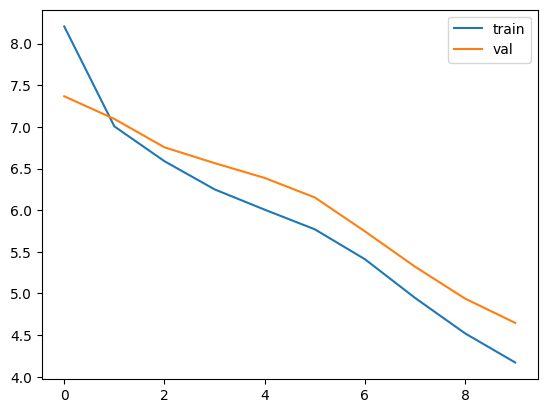

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [ ]:
loss = model.evaluate(
    [test_articles_seq, test_summaries_seq],  # Use the input articles and summaries, excluding the last word
    tf.expand_dims(test_summaries_seq, axis=-1)  # Use the target summaries, excluding the first word
)

print("Test Loss:", loss)

18/18 [==============================] - 72s 4s/step - loss: 4.7009
Test Loss: 4.700936317443848


In [ ]:
article_reverse_word_index=article_tokenizer.index_word
summary_reverse_word_index=summary_tokenizer.index_word

In [ ]:
def generate_text_predictions(articles, summaries):
    # Convert the texts to sequences
    article_sequences = article_tokenizer.texts_to_sequences(articles)
    article_sequences = pad_sequences(article_sequences, maxlen=500, padding='post')

    summary_sequences = summary_tokenizer.texts_to_sequences(summaries)
    summary_sequences = pad_sequences(summary_sequences, maxlen=50, padding='post')

    # Generate predictions
    predictions = model.predict([article_sequences, summary_sequences])

    # Convert predictions to text format
    prediction_sequences = []
    for pred in predictions:
        pred_indices = np.argmax(pred, axis=-1)
        prediction_sequences.append(pred_indices)

    text_predictions = summary_tokenizer.sequences_to_texts(prediction_sequences)
    
    return text_predictions

# Example usage:
articles = [
    """BOGOTA, Colombia (CNN) -- A key rebel commander and fugitive from a U.S. drug trafficking indictment was killed over the weekend in an air attack on a guerrilla encampment, the Colombian military said Monday. Alleged cocaine trafficker and FARC rebel Tomas Medina Caracas in an Interpol photo. Tomas Medina Caracas, known popularly as "El Negro Acacio," was a member of the high command of the Fuerzas Armadas Revolucionarias de Colombia and, according to Colombian and U.S. officials, helped manage the group's extensive cocaine trafficking network. He had been in the cross-hairs of the U.S. Justice Department since 2002. He was charged with conspiracy to import cocaine into the United States and manufacturing and distributing cocaine within Colombia to fund the FARC's 42-year insurgency against the government. U.S. officials alleged Medina Caracas managed the rebel group's sales of cocaine to international drug traffickers, who in turn smuggled it into the United States. He was also indicted in the United States along with two other FARC commanders in November 2002 on charges of conspiring to kidnap two U.S. oil workers from neighboring Venezuela in 1997 and holding one of them for nine months until a $1 million ransom was paid. Officials said the army's Rapid Response Force, backed by elements of the Colombian Air Force, tracked Medina Caracas down at a FARC camp in the jungle in the south of the country. "After a bombardment, the troops occupied the camp, and they've found 14 dead rebels so far, along with rifles, pistols, communications equipment and ... four GPS systems," Defense Minister Juan Manuel Santos said at a news conference. "The death of 'El Negro Acacio' was confirmed by various sources, including members of FARC itself." Medina Caracas commanded FARC's 16th Front in the southern departments of Vichada and Guainia. Established in 1964 as the military wing of the Colombian Communist Party, FARC is Colombia's oldest, largest, most capable and best-equipped Marxist rebel group, according to the U.S. Department of State. E-mail to a friend . Journalist Fernando Ramos contributed to this report."""
]

summaries = [
    """Tomas Medina Caracas was a fugitive from a U.S. drug trafficking indictment . "El Negro Acacio" allegedly helped manage extensive cocaine network . U.S. Justice Department indicted him in 2002 . Colombian military: He was killed in an attack on a guerrilla encampment ."""
]

predictions = generate_text_predictions(articles, summaries)
for text, summ, pred in zip(articles, summaries, predictions):
    print("Article:", text)
    print("Golden Summary:", summ)
    print("Prediction Summary:", pred)
    print()

1/1 [==============================] - 0s 489ms/step
prediction_sequences: [array([  5,  31,   3,   7,   5,   1,  16,   5,  67,  68,   0,   0,   1,
         1,  65, 236, 394,   0,   1,   0,   0,  67,  68,   0,   0,   1,
        56,   3,   0,   1,   0,  11,   7, 110,   3,  35,   0,   9,   5,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int64)]
Article: BOGOTA, Colombia (CNN) -- A key rebel commander and fugitive from a U.S. drug trafficking indictment was killed over the weekend in an air attack on a guerrilla encampment, the Colombian military said Monday. Alleged cocaine trafficker and FARC rebel Tomas Medina Caracas in an Interpol photo. Tomas Medina Caracas, known popularly as "El Negro Acacio," was a member of the high command of the Fuerzas Armadas Revolucionarias de Colombia and, according to Colombian and U.S. officials, helped manage the group's extensive cocaine trafficking network. He had been in the cross-hairs of the U.S. Justice Department since 200

In [ ]:
# import numpy as np
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.models import load_model

# def generate_text_predictions(articles, summaries):
#     model = load_model('text_generation_model.h5')  # Load the trained model
#     summary_tokenizer = Tokenizer()  # Create a new tokenizer for the summaries
#     summary_tokenizer.fit_on_texts(summaries)  # Fit the tokenizer on the summary texts
#     text_predictions = []

#     for article in articles:
#         sequences = summary_tokenizer.texts_to_sequences([article])  # Convert article text to sequences
#         input_data = pad_sequences(sequences, maxlen=1000)  # Pad the input sequence
#         pred = model.predict(input_data)  # Generate predictions
#         pred_indices = np.argmax(pred, axis=-1)
#         pred_indices_list = pred_indices.tolist()  # Convert numpy array to list
#         pred_text = summary_tokenizer.sequences_to_texts(pred_indices_list)
#         text_predictions.append(pred_text)

#     return text_predictions

# # Example usage
# articles = [
#     """BOGOTA, Colombia (CNN) -- A key rebel commander and fugitive from a U.S. drug trafficking indictment was killed over the weekend in an air attack on a guerrilla encampment, the Colombian military said Monday. Alleged cocaine trafficker and FARC rebel Tomas Medina Caracas in an Interpol photo. Tomas Medina Caracas, known popularly as "El Negro Acacio," was a member of the high command of the Fuerzas Armadas Revolucionarias de Colombia and, according to Colombian and U.S. officials, helped manage the group's extensive cocaine trafficking network. He had been in the cross-hairs of the U.S. Justice Department since 2002. He was charged with conspiracy to import cocaine into the United States and manufacturing and distributing cocaine within Colombia to fund the FARC's 42-year insurgency against the government. U.S. officials alleged Medina Caracas managed the rebel group's sales of cocaine to international drug traffickers, who in turn smuggled it into the United States. He was also indicted in the United States along with two other FARC commanders in November 2002 on charges of conspiring to kidnap two U.S. oil workers from neighboring Venezuela in 1997 and holding one of them for nine months until a $1 million ransom was paid. Officials said the army's Rapid Response Force, backed by elements of the Colombian Air Force, tracked Medina Caracas down at a FARC camp in the jungle in the south of the country. "After a bombardment, the troops occupied the camp, and they've found 14 dead rebels so far, along with rifles, pistols, communications equipment and ... four GPS systems," Defense Minister Juan Manuel Santos said at a news conference. "The death of 'El Negro Acacio' was confirmed by various sources, including members of FARC itself." Medina Caracas commanded FARC's 16th Front in the southern departments of Vichada and Guainia. Established in 1964 as the military wing of the Colombian Communist Party, FARC is Colombia's oldest, largest, most capable and best-equipped Marxist rebel group, according to the U.S. Department of State. E-mail to a friend . Journalist Fernando Ramos contributed to this report."""
# ]

# summaries = [
#     """Tomas Medina Caracas was a fugitive from a U.S. drug trafficking indictment . "El Negro Acacio" allegedly helped manage extensive cocaine network . U.S. Justice Department indicted him in 2002 . Colombian military: He was killed in an attack on a guerrilla encampment ."""
# ]

# predictions = generate_text_predictions(articles, summaries)

# for text, summ, pred in zip(articles, summaries, predictions):
#     print("Article:", text)
#     print("Summary:", summ)
#     print("Predicted Summary:", pred)
#     print()
